# Lab 11: Movie Classification
In this lab you will build a classifier that guesses whether a movie is a comedy or a thriller, using only the number of times words appear in the movies's screenplay. By the end of the lab, you should know how to:

1. Build a k-nearest-neighbors classifier.
2. Test a classifier on data.

To get started, run the cell below.

In [1]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# 1. The Dataset (Again)

In this lab we will again explore movie screenplays. We will be trying to predict each movie's genre from the text of its screenplay. In particular, we have compiled a list of 5,000 words that occur in conversations between movie characters. For each movie, our dataset tells us the frequency with which each of these words occurs in certain conversations in its screenplay. All words have been converted to lowercase.

Run the cell below to read the `movies` table.

In [2]:
movies = Table.read_table('movies.csv')
movies.where("Title", "wild wild west").select(0, 1, 2, 3, 4, 14, 49, 1042, 4004)

Title,Year,Rating,Genre,# Words,breez,england,it,bravo
wild wild west,1999,4.3,comedy,3446,0,0,0.0212635,0


The above cell prints a few columns of the row for the comedy movie *Wild Wild West*.  The movie contains 3446 words. The word "it" appears 74 times, as it makes up  $\frac{74}{3446} \approx 0.021364$ of the words in the movie. The word "england" doesn't appear at all.
This numerical representation of a body of text, one that describes only the frequencies of individual words, is called a bag-of-words representation. A lot of information is discarded in this representation: the order of the words, the context of each word, who said what, the cast of characters and actors, etc. However, a bag-of-words representation is often used for machine learning applications as a reasonable starting point, because a great deal of information is also retained and expressed in a convenient and compact format. In this project, we will investigate whether this representation is sufficient to build an accurate genre classifier.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

*Note: All movies in our dataset have their titles lower-cased.* 

In [3]:
title_index = movies.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    movies.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

For example, the fastest way to find the frequency of "none" in the movie *The Terminator* is to access the `'none'` item from its row. Check the original table to see if this worked for you!

In [4]:
row_for_title('the terminator').item('none') 

0.0009633911368015

## 1.1. Splitting the dataset
We're going to use our `movies` dataset for two purposes.

1. First, we want to *train* movie genre classifiers.
2. Second, we want to *test* the performance of our classifiers.

Hence, we need two different datasets: *training* and *test*.

The purpose of a classifier is to classify unseen data that is similar to the training data. Therefore, we must ensure that there are no movies that appear in both sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training and the rest for test. 

Run the code below (without changing it) to separate the datasets into two tables.

In [5]:
# Here we have defined the proportion of our data
# that we want to designate for training as 17/20ths
# of our total dataset.  3/20ths of the data is
# reserved for testing.

training_proportion = 17/20

num_movies = movies.num_rows
num_train = int(num_movies * training_proportion)
num_test = num_movies - num_train

train_movies = movies.take(np.arange(num_train))
test_movies = movies.take(np.arange(num_train, num_movies))

print("Training: ",   train_movies.num_rows, ";",
      "Test: ",       test_movies.num_rows)

Training:  314 ; Test:  56


# 2. K-Nearest Neighbors - A Guided Example

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some numerical *attributes* (also called *features*) of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples. Predicting the category of an example is called *labeling*, and the predicted category is also called a *label*.

An attribute (feature) we have about each movie is *the proportion of times a particular word appears in the movies*, and the labels are two movie genres: comedy and thriller.  The algorithm requires many previously seen examples for which both the attributes and labels are known: that's the `train_movies` table.

To build understanding, we're going to visualize the algorithm instead of just describing it.

## 2.1. Classifying a movie

In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features we choose. We call those movies with similar features the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each movie.  The features we will use are the proportions of the words "paid" and "rent" in the movie.  Taking the movie *Fast Times at Ridgemont High* (in the test set), 0.0001915341 of its words are "paid" and 0.0001915341 are "rent". This movie appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *distance* between two movies is the straight-line distance between them when we plot their features in a scatter diagram. 

This distance is called the Euclidean ("yoo-KLID-ee-un") distance, whose formula is: 
&nbsp;

<center> $ \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2} $ </center>
&nbsp;

For example, in the movie *Ghostbusters* (in the training set), 0.0002191060 of all the words in the movie are "paid" and 0 are "rent".  Its distance from *Fast Times at Ridgemont High* on this 2-word feature set is: 
&nbsp;

<center> $\sqrt{(0.0001915341 - 0.0002191060)^2 + (0.0001915341 - 0)^2} \approx 0.0001935084$. </center> 
&nbsp;

A third movie, *Point Break* (in the training set), is 0 "paid" and 0.0002754820 "rent".

The function below creates a plot to display the "paid" and "rent" features of a test movie and some training movies. As you can see in the result, *Fast Times at Ridgemont High* is more similar to *Ghostbusters* than to the *Point Break* based on these features, which makes sense as both movies are comedy movies, while *Point Break* is a thriller.


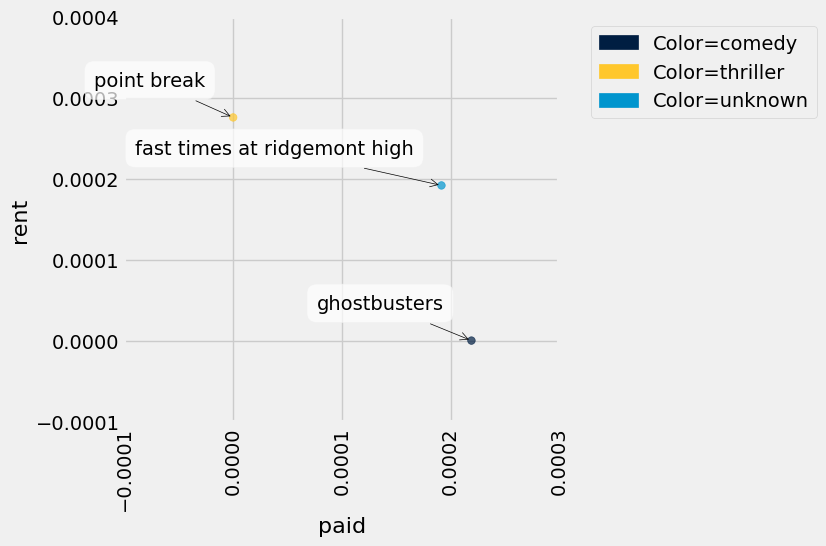

In [6]:
# Just run this cell.
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    distances = Table().with_columns(
            x_feature, [test_row.item(x_feature)],
            y_feature, [test_row.item(y_feature)],
            'Color',   ['unknown'],
            'Title',   [test_movie]
        )
    for movie in training_movies:
        row = row_for_title(movie)
        distances.append([row.item(x_feature), row.item(y_feature), row.item('Genre'), movie])
    distances.scatter(x_feature, y_feature, group='Color', labels='Title', s=30)
    
training = ["ghostbusters", "point break"] 
plot_with_two_features("fast times at ridgemont high", training, "paid", "rent")
plots.axis([-0.0001, 0.0003, -0.0001, 0.0004]);
plots.xticks(rotation=90);

#### Question 2.1.1

Compute the Euclidean distance (defined in the section above) between the two movies, *Fast Times at Ridgemont High* and *Point Break*, using the `paid` and `rent` features only.  Assign it the name `one_distance`.

**Note:** If you have a row, you can use `item` to get a value from a column by its name.  For example, if `r` is a row, then `r.item("Genre")` is the value in column `"Genre"` in row `r`.

*Hint*: Remember the function `row_for_title`, redefined for you below.

<!--
BEGIN QUESTION
name: q2_1_1
-->

In [9]:
title_index = movies.index_by('Title')
fast_times = row_for_title('fast times at ridgemont high') 
point_break = row_for_title("point break") 

one_distance = ((fast_times.item("paid") - point_break.item("paid")) ** 2 + (fast_times.item("rent") - point_break.item("rent")) ** 2) ** 0.5
one_distance

0.00020912339950768791

Below, we've added a third training movie, *The Abyss*. Before, the point closest to *Fast Times at Ridgemont High* was *Ghostbusters*, a comedy movie. However, now the closest point is *The Abyss*, a thriller movie.

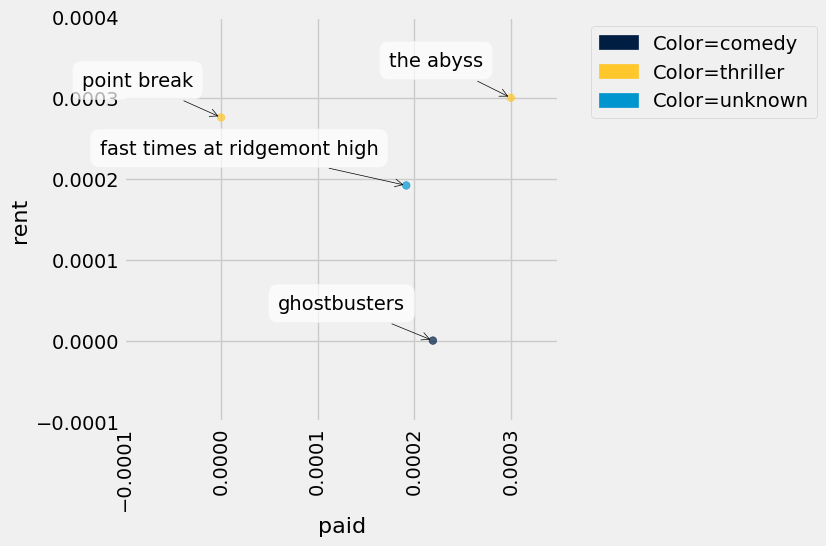

In [10]:
training = ["ghostbusters", "point break", "the abyss"] 
plot_with_two_features("fast times at ridgemont high", training, "paid", "rent") 
plots.axis([-0.0001, 0.00035, -0.0001, 0.0004]);
plots.xticks(rotation=90);

#### Question 2.1.2
Complete the function `distance_two_features` that computes the Euclidean distance between any two movies, using two features. The last two lines call your function to show that *Fast Times at Ridgemont High* is closer to *The Abyss* than it is to *Ghostbusters*. 

<!--
BEGIN QUESTION
name: q2_1_2
-->

In [11]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    row0 = row_for_title(title0)
    row1 = row_for_title(title1)
    return (((row0.item(x_feature) - row1.item(x_feature)) ** 2 + (row0.item(y_feature) - row1.item(y_feature)) ** 2) ** 0.5)

for movie in make_array("ghostbusters", "the abyss"):
    movie_distance = distance_two_features(movie, "fast times at ridgemont high", "paid", "rent")
    print(movie, 'distance:\t', movie_distance)

ghostbusters distance:	 0.000193508534383
the abyss distance:	 0.000153054681235


#### Question 2.1.3
Define the function `distance_from_fast_times` so that it works as described in its documentation.

**Note:** Your solution should not use arithmetic operations directly. Instead, it should make use of existing functionality above!

<!--
BEGIN QUESTION
name: q2_1_3
-->

In [13]:
def distance_from_fast_times(title):
    """The distance between the given movie and "fast times at ridgemont high", 
    based on the features "paid" and "rent".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    
    return distance_two_features(title, "fast times at ridgemont high", "paid", "rent")

#### Question 2.1.4

Using the features `"paid"` and `"rent"`, what are the names and genres of the 5 movies in the **training set** closest to *Fast Times at Ridgemont High*?  To answer this question, make a table named `close_movies` containing those 5 movies with columns `"Title"`, `"Genre"`, `"paid"`, and `"rent"`, as well as a column called `"distance from fast times"` that contains the distance from *Fast Times at Ridgemont High*.  The table should be **sorted in ascending order by `distance from fast times`**.

<!--
BEGIN QUESTION
name: q2_1_4
-->

In [34]:

# The staff solution took multiple lines.
train_movies_adjusted = train_movies.select("Title", "Genre", "paid", "rent")
close_movies = train_movies_adjusted.with_column("distance from fast times", train_movies_adjusted.apply(distance_from_fast_times, "Title")).sort("distance from fast times").take(np.arange(5))
close_movies

Title,Genre,paid,rent,distance from fast times
superman iii,comedy,0.00019857,0.00019857,9.95056e-06
hero,comedy,0.00020008,0.00020008,1.20856e-05
fight club,thriller,0.000171556,0.000171556,2.82534e-05
the family man,comedy,0.000171438,0.000171438,2.84198e-05
notting hill,comedy,0.000166583,0.000166583,3.52858e-05


### Question 2.1.5
Next, we'll classify *Fast Times at Ridgemont High* based on the genres of the closest movies. 

To do so, define the function `most_common` so that it works as described in its documentation below.

<!--
BEGIN QUESTION
name: q2_1_5
-->

In [37]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in that column of that table.
    In case of a tie, it returns any one of the most common values
    """
    return (table.group(label).sort("count", descending = True)).column(0).take(0)

most_common('Genre', close_movies)

'comedy'

Congratulations are in order -- you've classified your first movie! You correctly classified Fast Times at Ridgemont High as a comedy! You are done with Lab 11! In class we will expand on how we can use many features to perform classification.